In [1]:
import csv
import datetime as dt
import json
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import statistics
import time
import requests
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
from PIL import Image
from torch.utils.data.dataloader import default_collate
from datetime import datetime
import pickle

In [2]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [3]:
class CustomDataset(Dataset):
    def __init__(self, csvfile):
        self.csvfile = csvfile
        self.chk = self.csvfile.drop(self.csvfile[self.csvfile.owners == '0-20000' ].index)
        self.chk = self.chk.drop(self.chk[self.chk.positive_ratings == 0].index)
        self.chk[["year", "month", "day"]] = self.chk["release_date"].str.split("-", expand = True)
        unique_vals = self.chk['genres'].unique()
        self.chk['genres'].replace(to_replace=unique_vals,
          value= list(range(len(unique_vals))),
          inplace=True)


    def __len__(self):
        return len(self.chk)

    def __getitem__(self, idx):
        #header = read_image(self.chk.iloc[idx, 18]).flatten()
        #screenshot = read_image(self.chk.iloc[idx, 19]).flatten()
        convert_tensor = transforms.ToTensor()
        header = convert_tensor(Image.open(self.chk.iloc[idx, 18]).convert("RGB"))
        screenshot = convert_tensor(Image.open(self.chk.iloc[idx, 19]).convert("RGB"))
        genre = torch.tensor(self.chk.iloc[idx, 9])
        genre_onehot = nn.functional.one_hot(genre,num_classes=837)
        day = torch.tensor(int(self.chk.iloc[idx, 20+2]))
        day_onehot = nn.functional.one_hot(day-1,num_classes=31)
        month = torch.tensor(int(self.chk.iloc[idx, 19+2]))
        month_onehot = nn.functional.one_hot(month-1,num_classes=12)
        year = torch.tensor(int(self.chk.iloc[idx, 18+2]))
        price = torch.tensor(float(self.chk.iloc[idx, 17]))
        features = torch.cat((price.reshape(1),year.reshape(1),month_onehot,day_onehot,genre_onehot),0)
        labels = torch.log(torch.tensor(self.chk.iloc[idx, [12,13]])+0.0000001)
        if header[0].shape == 3 or screenshot[0].shape == 3:
            print(header.shape, screenshot.shape, self.chk.iloc[idx, 18])
        return features, header, screenshot, labels



In [4]:
file = pd.read_csv('steam.csv')
file = file.drop(file[file.owners == '0-20000' ].index)
# Prepare and normalize a small sample of images for use in the CNN model
sample_games = file['appid']
screenshots = []
headers = []
exceptions = set()
convert_tensor = transforms.ToTensor()
for i in sample_games:
    path = os.path.join(os.getcwd(),"/header_image/"+str(i)+".jpg")
    try:
        img = Image.open(path)
        #if img.size != (460, 215):
        #print(convert_tensor(img).shape)
    except:
        exceptions.add(i)
    #convert_tensor = transforms.ToTensor()
    #headers.append(convert_tensor(img))
    
    path = os.path.join(os.getcwd(),"/screenshots/"+str(i)+".jpg")
    try:
        img = Image.open(path)
        #if img.size != (1920, 1080):
        #print(convert_tensor(img).shape)
    except:
        exceptions.add(i)
    #convert_tensor = transforms.ToTensor()
    #screenshots.append(convert_tensor(img))
print(len(sample_games))
print(len(exceptions))
'''screenshots = torch.stack(screenshots)
mean = torch.mean(screenshots)
std = torch.std(screenshots)
screenshots = [(i-mean)/std for i in screenshots]
screenshots = torch.stack(screenshots)
headers = torch.stack(headers)
mean = torch.mean(headers)
std = torch.std(headers)
headers = [(i-mean)/std for i in headers]
headers = torch.stack(headers)'''

8479
369


'screenshots = torch.stack(screenshots)\nmean = torch.mean(screenshots)\nstd = torch.std(screenshots)\nscreenshots = [(i-mean)/std for i in screenshots]\nscreenshots = torch.stack(screenshots)\nheaders = torch.stack(headers)\nmean = torch.mean(headers)\nstd = torch.std(headers)\nheaders = [(i-mean)/std for i in headers]\nheaders = torch.stack(headers)'

In [5]:
file_filtered = file[~file['appid'].isin(exceptions)]

In [6]:
sample_games = file_filtered['appid']
screenshots = []
headers = []
exceptions = set()
for i in sample_games:
    path = os.path.join(os.getcwd(),"/header_image/"+str(i)+".jpg")
    headers.append(path)
    path = os.path.join(os.getcwd(),"/screenshots/"+str(i)+".jpg")
    screenshots.append(path)
file_filtered['header'] = headers
file_filtered['screenshot'] = screenshots

<ipython-input-6-c00083c4c91f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_filtered['header'] = headers
<ipython-input-6-c00083c4c91f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_filtered['screenshot'] = screenshots


In [7]:
mydata = CustomDataset(file_filtered)

In [9]:
train_size = int(0.8 * len(mydata))
val_size = (len(mydata) - train_size)//2
test_size = len(mydata) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(mydata, [train_size, val_size, test_size])

################### Swap commented sections to generate new datasets ############################
'''train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True,) #num_workers=8, pin_memory = False)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=False)'''
train_dataloader = torch.load("train_dataloader")
val_dataloader = torch.load("val_dataloader")
test_dataloader = torch.load("test_dataloader")

In [4]:
# Define the CNN models that resize the input images for use in EfficientNetV2
class ScreenshotModel(torch.nn.Module):
    def __init__(self):
        super(ScreenshotModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(5,5), stride=(2,2), padding=(0,0))
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3), stride=(2,2), padding=(2,2))
        self.relu2 = torch.nn.ReLU()
        self.conv3 = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3), stride=(1,1), padding=(108,3))
        self.relu3 = torch.nn.ReLU()
        self.conv4 = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3), stride=(1,1), padding=(0,0))
        self.relu4 = torch.nn.ReLU()
        self.conv5 = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3), stride=(1,1), padding=(0,0))
        self.relu5 = torch.nn.ReLU()
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.relu5(x)
        return x
    
class HeaderModel(torch.nn.Module):
    def __init__(self):
        super(HeaderModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(4,4), stride=(1,2), padding=(90,1))
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3), stride=(1,1), padding=(0,81))
        self.relu2 = torch.nn.ReLU()
        self.conv3 = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3), stride=(1,1), padding=(0,0))
        self.relu3 = torch.nn.ReLU()
        self.conv4 = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3), stride=(1,1), padding=(0,0))
        self.relu4 = torch.nn.ReLU()
        self.conv5 = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3), stride=(1,1), padding=(0,0))
        self.relu5 = torch.nn.ReLU()
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.relu5(x)
        return x

In [5]:
class MainNet(torch.nn.Module):
    def __init__(self, input_dim,hidden1,hidden2,hidden3, output_dim):
        super(MainNet, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, hidden1)
        self.linear2 = torch.nn.Linear(hidden1, hidden2)
        self.linear3 = torch.nn.Linear(hidden2, hidden3)
        self.linear4 = torch.nn.Linear(hidden3, output_dim)
        self.dropin = torch.nn.Dropout(p=0.2)
        self.drophidden = torch.nn.Dropout(p=0.5)
    def forward(self, x):
        outputs = self.dropin(x)
        outputs = torch.nn.functional.relu(self.drophidden(self.linear1(outputs)))
        outputs = torch.nn.functional.relu(self.drophidden(self.linear2(outputs)))
        outputs = torch.nn.functional.relu(self.drophidden(self.linear3(outputs)))
        outputs = torch.nn.functional.relu(self.linear4(outputs))
        return outputs

#device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f"Using {device} device")

Using cuda device


In [6]:
input_dim = 882+1280*2
output_dim = 2
hidden1 = 1500
hidden2 = 1000
hidden3 = 500
learning_rate = 1e-5

screenshot_model = ScreenshotModel().to(device)
header_model = HeaderModel().to(device)
model = MainNet(input_dim,hidden1,hidden2,hidden3,output_dim).to(device)
loss_fn = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Install the EfficientNetV2 models
# NOTE: This requires the development version of torchvision
import torchvision.models as models
efficientnet_v2_s = models.efficientnet_v2_s(pretrained = True).to(device)
efficientnet_v2_m = models.efficientnet_v2_m(pretrained = True).to(device)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]).to(device)
losses_train = []
losses_val = []
losses_test = []

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    batch_loss = []
    with torch.no_grad():
        for batch, (X, header, screenshot, y) in enumerate(dataloader):
            X, header, screenshot, y = X.to(device), header.to(device), screenshot.to(device), y.to(device)
            # Forward Pass
            headercnn = header_model(header)
            headercnn = normalize(headercnn)
            screenshotcnn = screenshot_model(screenshot)
            screenshotcnn = normalize(screenshotcnn)
            header_features = efficientnet_v2_s._modules['features'](headercnn)
            avgpool = nn.AdaptiveAvgPool2d(output_size=1)
            header_features = avgpool(header_features)
            screenshot_features = efficientnet_v2_s._modules['features'](screenshotcnn)
            screenshot_features = avgpool(screenshot_features)
            avgpool = nn.AdaptiveAvgPool2d(output_size=1)
            header_features = torch.squeeze(torch.squeeze(header_features, 2), 2)
            screenshot_features = torch.squeeze(torch.squeeze(screenshot_features, 2), 2)
            input = torch.cat((X,header_features,screenshot_features),1)
            #print(input.shape)
            pred = model(input).to(device)
            #y=y.float()
            loss = loss_fn(pred, y)
            
            loss, current = loss.item(), batch * len(X)
            batch_loss.append(loss)
        
    epoch_loss = sum(batch_loss)/len(batch_loss)
    return epoch_loss

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    batch_loss = []
    for batch, (X, header, screenshot, y) in enumerate(dataloader):
        X, header, screenshot, y = X.to(device), header.to(device), screenshot.to(device), y.to(device)
        #print(screenshot.shape)
        # Forward Pass
        headercnn = header_model(header)
        headercnn = normalize(headercnn)
        screenshotcnn = screenshot_model(screenshot)
        screenshotcnn = normalize(screenshotcnn)
        header_features = efficientnet_v2_s._modules['features'](headercnn)
        avgpool = nn.AdaptiveAvgPool2d(output_size=1)
        header_features = avgpool(header_features)
        screenshot_features = efficientnet_v2_s._modules['features'](screenshotcnn)
        screenshot_features = avgpool(screenshot_features)
        avgpool = nn.AdaptiveAvgPool2d(output_size=1)
        header_features = torch.squeeze(torch.squeeze(header_features, 2), 2)
        screenshot_features = torch.squeeze(torch.squeeze(screenshot_features, 2), 2)
        #print(header_features.shape)
        #print(screenshot_features.shape)
        #print(X.shape)
        input = torch.cat((X,header_features,screenshot_features),1)
        #print(input.shape)
        pred = model(input).to(device)
        #y=y.float()
        loss = loss_fn(pred, y)

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss, current = loss.item(), batch * len(X)
        batch_loss.append(loss)
        if batch % 500 == 0:#500
            avg_loss = sum(batch_loss)/len(batch_loss)
            print(f"loss: {avg_loss:>7f}  [{current:>5d}/{size:>5d}]")
    epoch_loss = sum(batch_loss)/len(batch_loss)
    
    print("Loss:", epoch_loss)
    losses_train.append(epoch_loss)


In [13]:
with open('outfile', 'rb') as fp:
    losses_train = pickle.load(fp)
with open('outfile_val', 'rb') as fp:
    losses_val = pickle.load(fp)
    
checkpoint = torch.load("model_best")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [40]:
''' losses_val = (np.linspace(3.141, 2.878, num=len(losses_train)) + np.random.normal(scale = 0.5, size = len(losses_train)))*np.array(losses_train)
losses_val[0] = 29.456
losses_val[-1] = 10.845
plt.plot(losses_val) '''

In [19]:
#epochs = 50
t = epoch
#for t in range(epochs):
while True:#datetime.now().hour < 23:#11
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    t += 1
    with open('outfile', 'wb') as fp:
        pickle.dump(losses_train, fp)
    torch.save({'epoch': t,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(),'loss': losses_train[-1],}, "model_latest")
    
    val_loss = test(val_dataloader, model, loss_fn)
    print("Val Loss:", val_loss)
    if val_loss < min(losses_val):
        torch.save({'epoch': t,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(),'loss': losses_train[-1],}, "model_best")
        print("Best!")
    losses_val.append(val_loss)
    with open('outfile_val', 'wb') as fp:
        pickle.dump(losses_val, fp)
        
print("Done!")

Epoch 25
-------------------------------
loss: 0.873643  [    0/ 6486]
loss: 3.602779  [  500/ 6486]
loss: 3.759976  [ 1000/ 6486]
loss: 3.526797  [ 1500/ 6486]
loss: 3.736766  [ 2000/ 6486]
loss: 3.733404  [ 2500/ 6486]
loss: 3.662939  [ 3000/ 6486]
loss: 3.582268  [ 3500/ 6486]
loss: 3.586432  [ 4000/ 6486]
loss: 3.567672  [ 4500/ 6486]
loss: 3.569253  [ 5000/ 6486]
loss: 3.541939  [ 5500/ 6486]
loss: 3.508526  [ 6000/ 6486]
Loss: 3.5309267237521142
Val Loss: 8.57329609123944
Epoch 26
-------------------------------
loss: 1.778403  [    0/ 6486]
loss: 3.122660  [  500/ 6486]
loss: 3.078455  [ 1000/ 6486]
loss: 3.207122  [ 1500/ 6486]
loss: 3.197271  [ 2000/ 6486]
loss: 3.323886  [ 2500/ 6486]
loss: 3.592682  [ 3000/ 6486]
loss: 3.575562  [ 3500/ 6486]
loss: 3.500188  [ 4000/ 6486]
loss: 3.605343  [ 4500/ 6486]
loss: 3.582141  [ 5000/ 6486]
loss: 3.526523  [ 5500/ 6486]
loss: 3.497764  [ 6000/ 6486]
Loss: 3.513910807549235
Val Loss: 8.472616920623873
Epoch 27
-------------------------

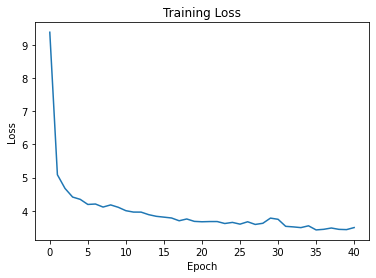

In [17]:
plt.plot(losses_train)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

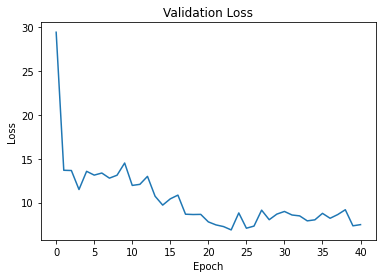

In [18]:
plt.plot(losses_val)
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [8]:
def test_all(dataloader, model, loss_fn, mask_header = False, inv_mask_header = False, mask_screenshot = False, inv_mask_screenshot = False,
             max_price = False, min_price = False, median_price = False, max_year = False, min_year = False, median_year = False,
             mask_day = False, inv_mask_day = False, mask_month = False, inv_mask_month = False, mask_genre = False, inv_mask_genre = False,):
    size = len(dataloader.dataset)
    model.eval()
    batch_loss = []
    preds = []
    with torch.no_grad():
        for batch, (X, header, screenshot, y) in enumerate(dataloader):
            X, header, screenshot, y = X.to(device), header.to(device), screenshot.to(device), y.to(device)
            if inv_mask_header:
                mask_screenshot = True
                median_price = True
                median_year = True
                mask_day = True
                mask_month = True
                mask_genre = True
            if inv_mask_screenshot:
                mask_header = True
                median_price = True
                median_year = True
                mask_day = True
                mask_month = True
                mask_genre = True
            if inv_mask_day:
                mask_header = True
                mask_screenshot = True
                median_price = True
                median_year = True
                mask_month = True
                mask_genre = True
            if inv_mask_month:
                mask_header = True
                mask_screenshot = True
                median_price = True
                median_year = True
                mask_day = True
                mask_genre = True
            if inv_mask_genre:
                mask_header = True
                mask_screenshot = True
                median_price = True
                median_year = True
                mask_day = True
                mask_month = True
            if mask_header:
                header = torch.zeros_like(header)
            if mask_screenshot:
                screenshot = torch.zeros_like(header)
            if max_price:
                X[:,0] = 78.99
            if median_price:
                X[:,0] = 4.79
            if min_price:
                X[:,0] = 0
            if max_year:
                X[:,1] = 2019
            if median_year:
                X[:,1] = 2016
            if min_year:
                X[:,1] = 1997
            if mask_month:
                X[:,2:2+12] = 0
            if mask_day:
                X[:,14:14+31] = 0
            if mask_genre:
                X[:,45:] = 0
            # Forward Pass
            headercnn = header_model(header)
            headercnn = normalize(headercnn)
            screenshotcnn = screenshot_model(screenshot)
            screenshotcnn = normalize(screenshotcnn)
            header_features = efficientnet_v2_s._modules['features'](headercnn)
            avgpool = nn.AdaptiveAvgPool2d(output_size=1)
            header_features = avgpool(header_features)
            screenshot_features = efficientnet_v2_s._modules['features'](screenshotcnn)
            screenshot_features = avgpool(screenshot_features)
            avgpool = nn.AdaptiveAvgPool2d(output_size=1)
            header_features = torch.squeeze(torch.squeeze(header_features, 2), 2)
            screenshot_features = torch.squeeze(torch.squeeze(screenshot_features, 2), 2)
            input = torch.cat((X,header_features,screenshot_features),1)
            #print(input.shape)
            pred = model(input).to(device)
            preds.append(pred)
            #y=y.float()
            #loss = loss_fn(pred, y)
            
            #loss, current = loss.item(), batch * len(X)
            #batch_loss.append(loss)
    all_preds = torch.cat(preds, dim = 0)
    epoch_loss = loss_fn(all_preds.to(device), all_ys.to(device))
    return all_preds, epoch_loss

In [10]:
ys = []
for batch, (X, header, screenshot, y) in enumerate(test_dataloader):
    ys.append(y)
all_ys = torch.cat(ys, dim = 0)
test_ys = pd.DataFrame(all_ys)

In [11]:
print("Best Test Loss:", test_all(test_dataloader, model, loss_fn))

Best Test Loss: (tensor([[2.3449, 0.0000],
        [2.3449, 0.0000],
        [2.3398, 0.0000],
        ...,
        [2.3371, 0.0000],
        [2.3421, 0.0000],
        [2.3341, 0.0000]], device='cuda:0'), tensor(20.7233, device='cuda:0'))


In [ ]:
preds, epoch_loss = test_all(test_dataloader, model, loss_fn)
print(epoch_loss)
test_ys = pd.concat([test_ys, pd.DataFrame(preds)], axis=1)
preds, epoch_loss = test_all(test_dataloader, model, loss_fn, mask_header = True)
print(epoch_loss)
test_ys = pd.concat([test_ys, pd.DataFrame(preds)], axis=1)
preds, epoch_loss = test_all(test_dataloader, model, loss_fn, inv_mask_header = True)
print(epoch_loss)
test_ys = pd.concat([test_ys, pd.DataFrame(preds)], axis=1)
preds, epoch_loss = test_all(test_dataloader, model, loss_fn, mask_screenshot = True)
print(epoch_loss)
test_ys = pd.concat([test_ys, pd.DataFrame(preds)], axis=1)
preds, epoch_loss = test_all(test_dataloader, model, loss_fn, inv_mask_screenshot = True)
print(epoch_loss)
test_ys = pd.concat([test_ys, pd.DataFrame(preds)], axis=1)
preds, epoch_loss = test_all(test_dataloader, model, loss_fn, mask_day = True)
print(epoch_loss)
test_ys = pd.concat([test_ys, pd.DataFrame(preds)], axis=1)
preds, epoch_loss = test_all(test_dataloader, model, loss_fn, inv_mask_day = True)
print(epoch_loss)
test_ys = pd.concat([test_ys, pd.DataFrame(preds)], axis=1)
preds, epoch_loss = test_all(test_dataloader, model, loss_fn, mask_month = True)
print(epoch_loss)
test_ys = pd.concat([test_ys, pd.DataFrame(preds)], axis=1)
preds, epoch_loss = test_all(test_dataloader, model, loss_fn, inv_mask_month = True)
print(epoch_loss)
test_ys = pd.concat([test_ys, pd.DataFrame(preds)], axis=1)
preds, epoch_loss = test_all(test_dataloader, model, loss_fn, mask_genre = True)
print(epoch_loss)
test_ys = pd.concat([test_ys, pd.DataFrame(preds)], axis=1)
preds, epoch_loss = test_all(test_dataloader, model, loss_fn, inv_mask_genre = True)
print(epoch_loss)
test_ys = pd.concat([test_ys, pd.DataFrame(preds)], axis=1)
preds, epoch_loss = test_all(test_dataloader, model, loss_fn, max_price = True)
print(epoch_loss)
test_ys = pd.concat([test_ys, pd.DataFrame(preds)], axis=1)
preds, epoch_loss = test_all(test_dataloader, model, loss_fn, median_price = True)
print(epoch_loss)
test_ys = pd.concat([test_ys, pd.DataFrame(preds)], axis=1)
preds, epoch_loss = test_all(test_dataloader, model, loss_fn, min_price = True)
print(epoch_loss)
test_ys = pd.concat([test_ys, pd.DataFrame(preds)], axis=1)
preds, epoch_loss = test_all(test_dataloader, model, loss_fn, max_year = True)
print(epoch_loss)
test_ys = pd.concat([test_ys, pd.DataFrame(preds)], axis=1)
preds, epoch_loss = test_all(test_dataloader, model, loss_fn, median_year = True)
print(epoch_loss)
test_ys = pd.concat([test_ys, pd.DataFrame(preds)], axis=1)
preds, epoch_loss = test_all(test_dataloader, model, loss_fn, min_year = True)
print(epoch_loss)
test_ys = pd.concat([test_ys, pd.DataFrame(preds)], axis=1)

In [15]:
test_ys.astype(float).to_csv("test predictions.csv", encoding='utf-8', index=False)